<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png?sfvrsn=764583a6_0' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

<h2> Code </h2> <a id="top"></a>

[Go to Report](#report)

In [1]:
# import the packages
from pyspark.sql import SparkSession
from pyspark.sql import Row

#Used to Count Null Values
from pyspark.sql.functions import col, isnan, when, count

#Used to handle null values
from pyspark.ml.feature import Imputer

#One Hot Encoding (PySpark)
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

#Vector Assembler
from pyspark.ml.feature import VectorAssembler

#Standard Scalar
from pyspark.ml.feature import StandardScaler

#Linear Regression
from pyspark.ml.regression import LinearRegression

### Step 1: Problem Statement Formulation

#### Step 1.1: Load the data from CSV File & Creating a copy of the data

In [2]:
# load and explore data
spark=SparkSession.builder.appName('DDP_Assignment 1').getOrCreate()
df=spark.read.csv('./data/sg_flat_prices_mod.csv', header=True, inferSchema=True)

#Creating a copy of the CSV for best practice
df_copy=spark.read.csv('./data/sg_flat_prices_mod.csv', header=True, inferSchema=True) 

#### Step 1.2: Data Exploration and Understanding

In [3]:
#Finding out the columns and its data types
df.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('town', 'string'),
 ('flat_type', 'string'),
 ('block', 'string'),
 ('street_name', 'string'),
 ('storey_range', 'string'),
 ('floor_area_sqm', 'double'),
 ('flat_model', 'string'),
 ('lease_commence_date', 'int'),
 ('remaining_lease', 'int'),
 ('resale_price', 'double')]

In [4]:
#Establishing the data is a recognisable format for the ease of viewing
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
df

year,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
2017,1,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,736,232000.0
2017,1,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,727,250000.0
2017,1,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,262000.0
2017,1,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,745,265000.0
2017,1,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,749,265000.0
2017,1,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,756,275000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,280000.0
2017,1,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,700,285000.0
2017,1,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,738,285000.0
2017,1,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,736,285000.0


In [5]:
#Example of one row of data with its column
df.show(1, vertical=True)

-RECORD 0--------------------------------
 year                | 2017              
 month               | 1                 
 town                | ANG MO KIO        
 flat_type           | 2 ROOM            
 block               | 406               
 street_name         | ANG MO KIO AVE 10 
 storey_range        | 10 TO 12          
 floor_area_sqm      | 44.0              
 flat_model          | Improved          
 lease_commence_date | 1979              
 remaining_lease     | 736               
 resale_price        | 232000.0          
only showing top 1 row



In [6]:
#All variables can have the potential of having null values
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- town: string (nullable = true)
 |-- flat_type: string (nullable = true)
 |-- block: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- storey_range: string (nullable = true)
 |-- floor_area_sqm: double (nullable = true)
 |-- flat_model: string (nullable = true)
 |-- lease_commence_date: integer (nullable = true)
 |-- remaining_lease: integer (nullable = true)
 |-- resale_price: double (nullable = true)



In [7]:
type(df)

pyspark.sql.dataframe.DataFrame

In [8]:
df.select('year', 'month', 'floor_area_sqm').describe().show()

+-------+------------------+------------------+-----------------+
|summary|              year|             month|   floor_area_sqm|
+-------+------------------+------------------+-----------------+
|  count|             64247|             64247|            64197|
|   mean|2018.0262424704656| 6.779133656046197|97.77009984890256|
| stddev|0.8146939469668695|3.2635673352950514|24.26994610142912|
|    min|              2017|                 1|             31.0|
|    max|              2019|                12|            249.0|
+-------+------------------+------------------+-----------------+



In [9]:
df.select('lease_commence_date', 'remaining_lease', 'resale_price').describe().show()

+-------+-------------------+------------------+------------------+
|summary|lease_commence_date|   remaining_lease|      resale_price|
+-------+-------------------+------------------+------------------+
|  count|              64247|             64247|             64247|
|   mean| 1993.6012420813422| 894.6413840334957|438943.70469516085|
| stddev| 12.465629502278013|149.62669792791093|153760.65294972394|
|    min|               1966|               553|          150000.0|
|    max|               2016|              1160|         1205000.0|
+-------+-------------------+------------------+------------------+



#### Trying to understand the context of the dataset

In [10]:
df.select('year').distinct().collect()

[Row(year=2018), Row(year=2019), Row(year=2017)]

In [11]:
df.select('town').distinct().collect()

[Row(town='QUEENSTOWN'),
 Row(town='BEDOK'),
 Row(town='CLEMENTI'),
 Row(town='SERANGOON'),
 Row(town='BUKIT PANJANG'),
 Row(town='BUKIT TIMAH'),
 Row(town='YISHUN'),
 Row(town='GEYLANG'),
 Row(town='WOODLANDS'),
 Row(town='BUKIT MERAH'),
 Row(town='TOA PAYOH'),
 Row(town='BISHAN'),
 Row(town='PUNGGOL'),
 Row(town='HOUGANG'),
 Row(town='ANG MO KIO'),
 Row(town='PASIR RIS'),
 Row(town='SENGKANG'),
 Row(town='KALLANG/WHAMPOA'),
 Row(town='BUKIT BATOK'),
 Row(town='TAMPINES'),
 Row(town='JURONG WEST'),
 Row(town='JURONG EAST'),
 Row(town='MARINE PARADE'),
 Row(town='CENTRAL AREA'),
 Row(town='SEMBAWANG'),
 Row(town='CHOA CHU KANG')]

In [12]:
df.select('flat_type').distinct().collect()

[Row(flat_type='3 ROOM'),
 Row(flat_type='1 ROOM'),
 Row(flat_type='4 ROOM'),
 Row(flat_type='2 ROOM'),
 Row(flat_type='EXECUTIVE'),
 Row(flat_type='5 ROOM'),
 Row(flat_type='MULTI-GENERATION')]

In [13]:
df.select('flat_model').distinct().collect()

[Row(flat_model='Apartment'),
 Row(flat_model='Premium Maisonette'),
 Row(flat_model='Improved'),
 Row(flat_model='Type S2'),
 Row(flat_model='New Generation'),
 Row(flat_model='Improved-Maisonette'),
 Row(flat_model='Model A-Maisonette'),
 Row(flat_model='Maisonette'),
 Row(flat_model='Multi Generation'),
 Row(flat_model='Model A'),
 Row(flat_model='DBSS'),
 Row(flat_model='Simplified'),
 Row(flat_model='Terrace'),
 Row(flat_model='Adjoined flat'),
 Row(flat_model='Type S1'),
 Row(flat_model='Standard'),
 Row(flat_model='Premium Apartment'),
 Row(flat_model='Model A2'),
 Row(flat_model='Premium Apartment Loft')]

In [14]:
df.select('lease_commence_date').distinct().collect()

[Row(lease_commence_date=1990),
 Row(lease_commence_date=1975),
 Row(lease_commence_date=1977),
 Row(lease_commence_date=2003),
 Row(lease_commence_date=2007),
 Row(lease_commence_date=1974),
 Row(lease_commence_date=2015),
 Row(lease_commence_date=2006),
 Row(lease_commence_date=1978),
 Row(lease_commence_date=2013),
 Row(lease_commence_date=1988),
 Row(lease_commence_date=1997),
 Row(lease_commence_date=1994),
 Row(lease_commence_date=1968),
 Row(lease_commence_date=2014),
 Row(lease_commence_date=1973),
 Row(lease_commence_date=1979),
 Row(lease_commence_date=1971),
 Row(lease_commence_date=1966),
 Row(lease_commence_date=2004),
 Row(lease_commence_date=1991),
 Row(lease_commence_date=1967),
 Row(lease_commence_date=1969),
 Row(lease_commence_date=1982),
 Row(lease_commence_date=1996),
 Row(lease_commence_date=1989),
 Row(lease_commence_date=1998),
 Row(lease_commence_date=1985),
 Row(lease_commence_date=1970),
 Row(lease_commence_date=2012),
 Row(lease_commence_date=1987),
 Row(lea

In [15]:
df.select('town').distinct().collect()

[Row(town='QUEENSTOWN'),
 Row(town='BEDOK'),
 Row(town='CLEMENTI'),
 Row(town='SERANGOON'),
 Row(town='BUKIT PANJANG'),
 Row(town='BUKIT TIMAH'),
 Row(town='YISHUN'),
 Row(town='GEYLANG'),
 Row(town='WOODLANDS'),
 Row(town='BUKIT MERAH'),
 Row(town='TOA PAYOH'),
 Row(town='BISHAN'),
 Row(town='PUNGGOL'),
 Row(town='HOUGANG'),
 Row(town='ANG MO KIO'),
 Row(town='PASIR RIS'),
 Row(town='SENGKANG'),
 Row(town='KALLANG/WHAMPOA'),
 Row(town='BUKIT BATOK'),
 Row(town='TAMPINES'),
 Row(town='JURONG WEST'),
 Row(town='JURONG EAST'),
 Row(town='MARINE PARADE'),
 Row(town='CENTRAL AREA'),
 Row(town='SEMBAWANG'),
 Row(town='CHOA CHU KANG')]

In [16]:
df.select("town","lease_commence_date").groupBy("town").max().show()

+---------------+------------------------+
|           town|max(lease_commence_date)|
+---------------+------------------------+
|     QUEENSTOWN|                    2015|
|          BEDOK|                    2014|
|       CLEMENTI|                    2013|
|      SERANGOON|                    1999|
|  BUKIT PANJANG|                    2015|
|    BUKIT TIMAH|                    1989|
|         YISHUN|                    2016|
|        GEYLANG|                    2011|
|      WOODLANDS|                    2015|
|    BUKIT MERAH|                    2016|
|      TOA PAYOH|                    2012|
|         BISHAN|                    2011|
|        PUNGGOL|                    2016|
|        HOUGANG|                    2016|
|     ANG MO KIO|                    2015|
|      PASIR RIS|                    2015|
|       SENGKANG|                    2016|
|KALLANG/WHAMPOA|                    2012|
|    BUKIT BATOK|                    2005|
|       TAMPINES|                    2015|
+----------

In [17]:
df.select("town","lease_commence_date").groupBy("town").min().show()

+---------------+------------------------+
|           town|min(lease_commence_date)|
+---------------+------------------------+
|     QUEENSTOWN|                    1967|
|          BEDOK|                    1972|
|       CLEMENTI|                    1978|
|      SERANGOON|                    1978|
|  BUKIT PANJANG|                    1986|
|    BUKIT TIMAH|                    1974|
|         YISHUN|                    1978|
|        GEYLANG|                    1967|
|      WOODLANDS|                    1974|
|    BUKIT MERAH|                    1967|
|      TOA PAYOH|                    1967|
|         BISHAN|                    1973|
|        PUNGGOL|                    2002|
|        HOUGANG|                    1975|
|     ANG MO KIO|                    1976|
|      PASIR RIS|                    1980|
|       SENGKANG|                    1998|
|KALLANG/WHAMPOA|                    1969|
|    BUKIT BATOK|                    1983|
|       TAMPINES|                    1982|
+----------

In [18]:
df.select("town","lease_commence_date").groupBy("town").mean().show()

+---------------+------------------------+
|           town|avg(lease_commence_date)|
+---------------+------------------------+
|     QUEENSTOWN|       1990.153981264637|
|          BEDOK|      1983.6955380577429|
|       CLEMENTI|      1986.4932287954384|
|      SERANGOON|      1988.0617935192163|
|  BUKIT PANJANG|      1999.2827181208054|
|    BUKIT TIMAH|       1983.968253968254|
|         YISHUN|      1992.8806831294714|
|        GEYLANG|      1982.8140283140283|
|      WOODLANDS|       1996.879711307137|
|    BUKIT MERAH|      1991.0806826997673|
|      TOA PAYOH|      1986.0169413919414|
|         BISHAN|      1990.2271293375395|
|        PUNGGOL|      2010.0436082731123|
|        HOUGANG|      1991.6770623742455|
|     ANG MO KIO|      1984.2516283853274|
|      PASIR RIS|      1993.5294117647059|
|       SENGKANG|      2006.5790744466801|
|KALLANG/WHAMPOA|       1986.599686847599|
|    BUKIT BATOK|      1989.1015911872705|
|       TAMPINES|      1990.8865196078432|
+----------

#### Step 1.3: Value Based Problem Statement**

Given the variables of the HDB such as the year it was sold, the age of the flat when it was sold, the type of flat, and other variables finds the resale price of a given HDB flat. 


This would allow potential HDB buyers to gauge the costs of an HDB flat given a set of variables and details which will give these buyers the convenience to know if they can afford an HDB flat given the conditions and find out if the prices are matched to previous sales.

### Step 2: Exploratory Data Analysis and Data Cleansing

In [19]:
df.show()

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|2017|    1|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|            727|    250000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|            749|    262000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  465|ANG MO KIO AVE 10|    04 TO 06|          68.0|New Generation|

In [20]:
df.dtypes

[('year', 'int'),
 ('month', 'int'),
 ('town', 'string'),
 ('flat_type', 'string'),
 ('block', 'string'),
 ('street_name', 'string'),
 ('storey_range', 'string'),
 ('floor_area_sqm', 'double'),
 ('flat_model', 'string'),
 ('lease_commence_date', 'int'),
 ('remaining_lease', 'int'),
 ('resale_price', 'double')]

In [21]:
df.select('block').distinct().collect()

[Row(block='467'),
 Row(block='262B'),
 Row(block='296'),
 Row(block='829'),
 Row(block='101D'),
 Row(block='675'),
 Row(block='691'),
 Row(block='477A'),
 Row(block='663D'),
 Row(block='59B'),
 Row(block='451'),
 Row(block='853'),
 Row(block='125'),
 Row(block='439A'),
 Row(block='116B'),
 Row(block='944'),
 Row(block='788E'),
 Row(block='677B'),
 Row(block='800'),
 Row(block='219C'),
 Row(block='919'),
 Row(block='926'),
 Row(block='870'),
 Row(block='681A'),
 Row(block='700B'),
 Row(block='666'),
 Row(block='17A'),
 Row(block='635B'),
 Row(block='447'),
 Row(block='7'),
 Row(block='124'),
 Row(block='273A'),
 Row(block='51'),
 Row(block='506A'),
 Row(block='656D'),
 Row(block='176B'),
 Row(block='289C'),
 Row(block='468D'),
 Row(block='684A'),
 Row(block='989D'),
 Row(block='333D'),
 Row(block='280A'),
 Row(block='475'),
 Row(block='613'),
 Row(block='289E'),
 Row(block='307'),
 Row(block='185C'),
 Row(block='311A'),
 Row(block='718'),
 Row(block='574'),
 Row(block='409A'),
 Row(blo

In [22]:
#Overview of the columns with a row of data for understanding
df.show(1, vertical=True)

#Also, cross checking the data types according to the cell above
#To ensure that pyspark identifies the correct data types
#Block seems to be in the wrong data type but is correct
#Block can contain letters (Ex. 123A)

-RECORD 0--------------------------------
 year                | 2017              
 month               | 1                 
 town                | ANG MO KIO        
 flat_type           | 2 ROOM            
 block               | 406               
 street_name         | ANG MO KIO AVE 10 
 storey_range        | 10 TO 12          
 floor_area_sqm      | 44.0              
 flat_model          | Improved          
 lease_commence_date | 1979              
 remaining_lease     | 736               
 resale_price        | 232000.0          
only showing top 1 row



#### Data Exploration

In [23]:
df_DE1 = df.select(["flat_type", "resale_price"]).groupBy('flat_type').avg().sort("flat_type").show()

+----------------+------------------+
|       flat_type| avg(resale_price)|
+----------------+------------------+
|          1 ROOM| 186181.6551724138|
|          2 ROOM|233600.68988030468|
|          3 ROOM| 307712.2837821541|
|          4 ROOM| 432760.1087740674|
|          5 ROOM| 528812.8562151295|
|       EXECUTIVE| 625390.6592435675|
|MULTI-GENERATION| 806804.6060606061|
+----------------+------------------+



In [24]:
df_DE2 = df.select(["town", "resale_price"]).groupBy('town').avg().sort("avg(resale_price)", ascending=True).show()

+---------------+------------------+
|           town| avg(resale_price)|
+---------------+------------------+
|         YISHUN| 359988.7258250635|
|      WOODLANDS|376810.78428227745|
|    BUKIT BATOK| 377715.2757037944|
|      SEMBAWANG| 378804.1880729761|
|  CHOA CHU KANG|384960.08120300755|
|    JURONG WEST| 387879.4531122346|
|          BEDOK| 410944.0495771362|
|     ANG MO KIO| 411547.1964346932|
|    JURONG EAST| 416185.7745504841|
|  BUKIT PANJANG|428196.38632550335|
|        HOUGANG|429212.74610328645|
|        GEYLANG|430605.67181467183|
|       SENGKANG|433994.11826156947|
|        PUNGGOL| 453269.6137253925|
|       CLEMENTI| 469028.6115466857|
|       TAMPINES|474205.32034313725|
|      SERANGOON| 490769.0934438583|
|      PASIR RIS| 492123.0871459695|
|      TOA PAYOH| 494166.7532051282|
|KALLANG/WHAMPOA|496043.73121085594|
+---------------+------------------+
only showing top 20 rows



#### Checking string values that may share the same meaning but different naming convention

In [25]:
df.select('town').distinct().collect()

[Row(town='QUEENSTOWN'),
 Row(town='BEDOK'),
 Row(town='CLEMENTI'),
 Row(town='SERANGOON'),
 Row(town='BUKIT PANJANG'),
 Row(town='BUKIT TIMAH'),
 Row(town='YISHUN'),
 Row(town='GEYLANG'),
 Row(town='WOODLANDS'),
 Row(town='BUKIT MERAH'),
 Row(town='TOA PAYOH'),
 Row(town='BISHAN'),
 Row(town='PUNGGOL'),
 Row(town='HOUGANG'),
 Row(town='ANG MO KIO'),
 Row(town='PASIR RIS'),
 Row(town='SENGKANG'),
 Row(town='KALLANG/WHAMPOA'),
 Row(town='BUKIT BATOK'),
 Row(town='TAMPINES'),
 Row(town='JURONG WEST'),
 Row(town='JURONG EAST'),
 Row(town='MARINE PARADE'),
 Row(town='CENTRAL AREA'),
 Row(town='SEMBAWANG'),
 Row(town='CHOA CHU KANG')]

In [26]:
df.select('flat_type').distinct().collect()

[Row(flat_type='3 ROOM'),
 Row(flat_type='1 ROOM'),
 Row(flat_type='4 ROOM'),
 Row(flat_type='2 ROOM'),
 Row(flat_type='EXECUTIVE'),
 Row(flat_type='5 ROOM'),
 Row(flat_type='MULTI-GENERATION')]

In [27]:
df.select('street_name').distinct().collect()

[Row(street_name='BEDOK STH AVE 3'),
 Row(street_name='JURONG EAST ST 32'),
 Row(street_name='NTH BRIDGE RD'),
 Row(street_name='BEDOK NTH ST 2'),
 Row(street_name='CRAWFORD LANE'),
 Row(street_name='ANG MO KIO ST 21'),
 Row(street_name='SEMBAWANG CRES'),
 Row(street_name='RIVERVALE DR'),
 Row(street_name='WOODLANDS DR 60'),
 Row(street_name='LIM LIAK ST'),
 Row(street_name='BEDOK NTH AVE 3'),
 Row(street_name='CHOA CHU KANG NTH 6'),
 Row(street_name='LOR 8 TOA PAYOH'),
 Row(street_name='JOO SENG RD'),
 Row(street_name='TAO CHING RD'),
 Row(street_name='CHOA CHU KANG ST 53'),
 Row(street_name='PUNGGOL PL'),
 Row(street_name='JLN DAMAI'),
 Row(street_name='MCNAIR RD'),
 Row(street_name='EVERTON PK'),
 Row(street_name='BT BATOK ST 25'),
 Row(street_name='JLN BT HO SWEE'),
 Row(street_name='KALLANG BAHRU'),
 Row(street_name='YISHUN ST 20'),
 Row(street_name='BEDOK NTH ST 4'),
 Row(street_name='SERANGOON NTH AVE 3'),
 Row(street_name='ANG MO KIO AVE 8'),
 Row(street_name='QUEEN ST'),
 Row(

In [28]:
df.select('storey_range').distinct().collect()

[Row(storey_range='43 TO 45'),
 Row(storey_range='37 TO 39'),
 Row(storey_range='10 TO 12'),
 Row(storey_range='04 TO 06'),
 Row(storey_range='40 TO 42'),
 Row(storey_range='16 TO 18'),
 Row(storey_range='19 TO 21'),
 Row(storey_range='34 TO 36'),
 Row(storey_range='31 TO 33'),
 Row(storey_range='13 TO 15'),
 Row(storey_range='46 TO 48'),
 Row(storey_range='22 TO 24'),
 Row(storey_range='25 TO 27'),
 Row(storey_range='07 TO 09'),
 Row(storey_range='01 TO 03'),
 Row(storey_range='28 TO 30'),
 Row(storey_range='49 TO 51')]

In [29]:
df.select('flat_model').distinct().collect()

[Row(flat_model='Apartment'),
 Row(flat_model='Premium Maisonette'),
 Row(flat_model='Improved'),
 Row(flat_model='Type S2'),
 Row(flat_model='New Generation'),
 Row(flat_model='Improved-Maisonette'),
 Row(flat_model='Model A-Maisonette'),
 Row(flat_model='Maisonette'),
 Row(flat_model='Multi Generation'),
 Row(flat_model='Model A'),
 Row(flat_model='DBSS'),
 Row(flat_model='Simplified'),
 Row(flat_model='Terrace'),
 Row(flat_model='Adjoined flat'),
 Row(flat_model='Type S1'),
 Row(flat_model='Standard'),
 Row(flat_model='Premium Apartment'),
 Row(flat_model='Model A2'),
 Row(flat_model='Premium Apartment Loft')]

#### Step 2.1: Grouping

In [30]:
#Average of each columns grouped by the different flat types
df.groupby('flat_type').avg()

flat_type,avg(year),avg(month),avg(floor_area_sqm),avg(lease_commence_date),avg(remaining_lease),avg(resale_price)
3 ROOM,2018.0241195714927,6.7736224260696645,68.29045480787735,1984.083520431073,779.8618897940855,307712.2837821541
1 ROOM,2018.0689655172414,5.827586206896552,31.0,1975.0,668.5172413793103,186181.6551724138
4 ROOM,2018.0238041516245,6.782039711191335,95.56707105719238,1997.065959687124,936.4632972322503,432760.1087740674
2 ROOM,2018.2121871599566,6.9162132752992385,45.869423286180634,1995.4036996735583,913.0533188248096,233600.68988030468
EXECUTIVE,2018.0087057457922,6.700909266782744,144.30160572644613,1993.595473012188,895.2505320177984,625390.6592435675
5 ROOM,2018.0267026891179,6.7964940939934655,118.18541090726313,1997.0799195777834,936.5038326212616,528812.8562151295
MULTI-GENERATION,2018.3030303030303,7.9393939393939394,164.8181818181818,1987.060606060606,815.0909090909091,806804.6060606061


In [31]:
#Finding out the Max Resale price for each flat type
df.groupBy('flat_type').max().show()

+----------------+---------+----------+-------------------+------------------------+--------------------+-----------------+
|       flat_type|max(year)|max(month)|max(floor_area_sqm)|max(lease_commence_date)|max(remaining_lease)|max(resale_price)|
+----------------+---------+----------+-------------------+------------------------+--------------------+-----------------+
|          3 ROOM|     2019|        12|              249.0|                    2016|                1160|        1185000.0|
|          1 ROOM|     2019|        11|               31.0|                    1975|                 684|         232000.0|
|          4 ROOM|     2019|        12|              135.0|                    2016|                1160|        1110000.0|
|          2 ROOM|     2019|        12|               60.0|                    2015|                1159|         418000.0|
|       EXECUTIVE|     2019|        12|              215.0|                    2004|                1034|        1160000.0|
|       

In [32]:
df.groupBy('flat_type').count().show()

+----------------+-----+
|       flat_type|count|
+----------------+-----+
|          3 ROOM|15589|
|          1 ROOM|   29|
|          4 ROOM|26592|
|          2 ROOM|  919|
|       EXECUTIVE| 5169|
|          5 ROOM|15916|
|MULTI-GENERATION|   33|
+----------------+-----+



In [33]:
df.select("storey_range", "resale_price").groupBy("storey_range").mean().sort("storey_range").show()

+------------+------------------+
|storey_range| avg(resale_price)|
+------------+------------------+
|    01 TO 03| 394274.2836198463|
|    04 TO 06| 412115.9694568433|
|    07 TO 09|423477.66865580005|
|    10 TO 12|438086.75250713184|
|    13 TO 15|472987.87508488825|
|    16 TO 18|514570.93940520444|
|    19 TO 21| 591394.6781223805|
|    22 TO 24| 610122.5498092031|
|    25 TO 27| 666919.1401295896|
|    28 TO 30| 751391.7605177993|
|    31 TO 33| 800630.9291338583|
|    34 TO 36| 802757.8962962963|
|    37 TO 39| 845602.7674418605|
|    40 TO 42|       894045.9375|
|    43 TO 45|1037833.3333333334|
|    46 TO 48|1018845.4545454546|
|    49 TO 51|1022814.6666666666|
+------------+------------------+



In [34]:
df.select("storey_range").groupBy("storey_range").count().sort("storey_range")

storey_range,count
01 TO 03,11448
04 TO 06,14876
07 TO 09,13681
10 TO 12,12269
13 TO 15,5949
16 TO 18,2690
19 TO 21,1193
22 TO 24,891
25 TO 27,463
28 TO 30,309


#### Step 2.2: Filtering

In [35]:
#Filtering to show 5 Room flat that is more than or equal to 2018
#Show the floor_area_sqm and resale price
df.filter((df["year"]>=2018) & (df["flat_type"]=="5 ROOM")).select(['floor_area_sqm', 'resale_price']).show()

+--------------+------------+
|floor_area_sqm|resale_price|
+--------------+------------+
|         118.0|    530000.0|
|         119.0|    560000.0|
|         120.0|    568888.0|
|         137.0|    590000.0|
|         112.0|    608000.0|
|         119.0|    630000.0|
|         117.0|    873388.0|
|         120.0|    875000.0|
|         120.0|    880000.0|
|         117.0|    535000.0|
|         126.0|    550008.0|
|         119.0|    565000.0|
|         127.0|    613000.0|
|         117.0|    615000.0|
|         122.0|    630000.0|
|         118.0|    650000.0|
|         115.0|    660000.0|
|         117.0|    719888.0|
|         120.0|    680000.0|
|         121.0|    720000.0|
+--------------+------------+
only showing top 20 rows



#### Step 2.3: Additional Columns (flat_age_of_sale)


In [36]:
df = df.withColumn('flat_age_of_sale', col('year')-col('lease_commence_date'))
df.show()

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+----------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|flat_age_of_sale|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+----------------+
|2017|    1|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|              38|
|2017|    1|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|            727|    250000.0|              39|
|2017|    1|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|            749|    262000.0|              37

#### Step 2.4: Drop Unecessary Columns

In [37]:
df.show(1, vertical=True)

-RECORD 0--------------------------------
 year                | 2017              
 month               | 1                 
 town                | ANG MO KIO        
 flat_type           | 2 ROOM            
 block               | 406               
 street_name         | ANG MO KIO AVE 10 
 storey_range        | 10 TO 12          
 floor_area_sqm      | 44.0              
 flat_model          | Improved          
 lease_commence_date | 1979              
 remaining_lease     | 736               
 resale_price        | 232000.0          
 flat_age_of_sale    | 38                
only showing top 1 row



In [38]:
df = df.drop('block', 'street_name')
df.show(1, vertical=True)

-RECORD 0-------------------------
 year                | 2017       
 month               | 1          
 town                | ANG MO KIO 
 flat_type           | 2 ROOM     
 storey_range        | 10 TO 12   
 floor_area_sqm      | 44.0       
 flat_model          | Improved   
 lease_commence_date | 1979       
 remaining_lease     | 736        
 resale_price        | 232000.0   
 flat_age_of_sale    | 38         
only showing top 1 row



#### Step 2.5: Finding the columns that contains NULL values

In [39]:
#Finding the columns that contains null values
df.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in df.columns]).show()

#However since there are a large number of rows, it can be hard to view
#So, I decided to split to showcase them in seperate tables

+----+-----+----+---------+------------+--------------+----------+-------------------+---------------+------------+----------------+
|year|month|town|flat_type|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|flat_age_of_sale|
+----+-----+----+---------+------------+--------------+----------+-------------------+---------------+------------+----------------+
|   0|    0|   0|        0|           0|            50|         0|                  0|              0|           0|               0|
+----+-----+----+---------+------------+--------------+----------+-------------------+---------------+------------+----------------+



In [40]:
#Defining the 2 different columns for ease of readability as it will not be stacked
df1c = ['year', 'month', 'town', 'flat_type', 'storey_range', 'floor_area_sqm']
df2c = ['flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price', 'flat_age_of_sale']

In [41]:
#Column 1 variables with null values 
#Floor_area_sqm contains 50 null values
df.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in df1c]).show()

+----+-----+----+---------+------------+--------------+
|year|month|town|flat_type|storey_range|floor_area_sqm|
+----+-----+----+---------+------------+--------------+
|   0|    0|   0|        0|           0|            50|
+----+-----+----+---------+------------+--------------+



In [42]:
#Column 2 variables with null values
df.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in df2c]).show()

+----------+-------------------+---------------+------------+----------------+
|flat_model|lease_commence_date|remaining_lease|resale_price|flat_age_of_sale|
+----------+-------------------+---------------+------------+----------------+
|         0|                  0|              0|           0|               0|
+----------+-------------------+---------------+------------+----------------+



In [43]:
df.filter(df.floor_area_sqm.isNull())

year,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,flat_age_of_sale
2017,3,QUEENSTOWN,4 ROOM,19 TO 21,null,Improved,1970,628,556000.0,47
2017,3,TOA PAYOH,4 ROOM,16 TO 18,null,Improved,1976,698,383000.0,41
2017,3,TOA PAYOH,4 ROOM,16 TO 18,null,Improved,1975,683,390000.0,42
2017,3,TOA PAYOH,4 ROOM,13 TO 15,null,Improved,1973,664,420000.0,44
2017,3,TOA PAYOH,4 ROOM,07 TO 09,null,Improved,1973,664,420000.0,44
2017,4,BEDOK,4 ROOM,01 TO 03,null,Improved,1977,713,320000.0,40
2017,4,BEDOK,4 ROOM,04 TO 06,null,Improved,1977,713,352000.0,40
2017,4,BEDOK,4 ROOM,07 TO 09,null,Improved,1977,713,365000.0,40
2017,4,BEDOK,4 ROOM,13 TO 15,null,Improved,1977,713,385000.0,40
2017,4,BUKIT MERAH,4 ROOM,04 TO 06,null,Improved,1973,657,420000.0,44


#### Step 2.5.1: Closed Case Analysis (Drop NA Values)
##### Dropping rows with null values (50/64248 rows) 

In [44]:
df = df.na.drop()

In [45]:
#Dropping the 50 variables
df.count()

#64248 - 50 = 64197 rows

64197

In [46]:
#No more null values in the floor_area_sqm column
df.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in df1c]).show()

+----+-----+----+---------+------------+--------------+
|year|month|town|flat_type|storey_range|floor_area_sqm|
+----+-----+----+---------+------------+--------------+
|   0|    0|   0|        0|           0|             0|
+----+-----+----+---------+------------+--------------+



#### Step 2.5.2: Median Imputer (Replacing null values with Median)

In [47]:
imputer = Imputer(
    inputCols=['floor_area_sqm'], 
    outputCols=["{}_imputed".format(c) for c in ['floor_area_sqm']]
    ).setStrategy("median")

In [48]:
df_median_imputer = imputer.fit(df).transform(df)
df_median_imputer.show()
df_median_imputer.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in df1c]).show()

+----+-----+----------+---------+------------+--------------+--------------+-------------------+---------------+------------+----------------+----------------------+
|year|month|      town|flat_type|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|flat_age_of_sale|floor_area_sqm_imputed|
+----+-----+----------+---------+------------+--------------+--------------+-------------------+---------------+------------+----------------+----------------------+
|2017|    1|ANG MO KIO|   2 ROOM|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|              38|                  44.0|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|          67.0|New Generation|               1978|            727|    250000.0|              39|                  67.0|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|          67.0|New Generation|               1980|            749|    262000.0|              37|                  67.0|
|201

#### Step 2.5.2: Mean Imputer (Replacing null values with Mean)

In [49]:
imputer = Imputer(
    inputCols=['floor_area_sqm'], 
    outputCols=["{}_imputed".format(c) for c in ['floor_area_sqm']]
    ).setStrategy("mean")

In [50]:
df_mean_imputer = imputer.fit(df).transform(df)
df_mean_imputer.show()
df_mean_imputer.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in df1c]).show()

+----+-----+----------+---------+------------+--------------+--------------+-------------------+---------------+------------+----------------+----------------------+
|year|month|      town|flat_type|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|flat_age_of_sale|floor_area_sqm_imputed|
+----+-----+----------+---------+------------+--------------+--------------+-------------------+---------------+------------+----------------+----------------------+
|2017|    1|ANG MO KIO|   2 ROOM|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|              38|                  44.0|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|          67.0|New Generation|               1978|            727|    250000.0|              39|                  67.0|
|2017|    1|ANG MO KIO|   3 ROOM|    01 TO 03|          67.0|New Generation|               1980|            749|    262000.0|              37|                  67.0|
|201

### Step 3: Data Wrangling and Categorical Transformation

#### String Indexing + OHE

In [51]:
#Remove once done
df.show(1, vertical=True)

-RECORD 0-------------------------
 year                | 2017       
 month               | 1          
 town                | ANG MO KIO 
 flat_type           | 2 ROOM     
 storey_range        | 10 TO 12   
 floor_area_sqm      | 44.0       
 flat_model          | Improved   
 lease_commence_date | 1979       
 remaining_lease     | 736        
 resale_price        | 232000.0   
 flat_age_of_sale    | 38         
only showing top 1 row



In [52]:
string_var = ["town", "flat_type", "storey_range", "flat_model"]

In [53]:
stage_string = [StringIndexer(inputCol= c, outputCol= c+"_si") for c in string_var]
stage_one_hot = [OneHotEncoder(inputCol= c+"_si", outputCol= c+ "_OHE") for c in string_var]

In [54]:
#Adding the encoded columns
ppl = Pipeline(stages= stage_string + stage_one_hot)
pyspark_indexing_OHE = ppl.fit(df).transform(df)
pyspark_indexing_OHE.show(3)

+----+-----+----------+---------+------------+--------------+--------------+-------------------+---------------+------------+----------------+-------+------------+---------------+-------------+--------------+-------------+----------------+--------------+
|year|month|      town|flat_type|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|flat_age_of_sale|town_si|flat_type_si|storey_range_si|flat_model_si|      town_OHE|flat_type_OHE|storey_range_OHE|flat_model_OHE|
+----+-----+----------+---------+------------+--------------+--------------+-------------------+---------------+------------+----------------+-------+------------+---------------+-------------+--------------+-------------+----------------+--------------+
|2017|    1|ANG MO KIO|   2 ROOM|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|              38|    8.0|         4.0|            2.0|          1.0|(25,[8],[1.0])|(6,[4],[1.0])|  (16,[2],[1.

In [55]:
#Dropping of Original Strings
pyspark_indexing_OHE = pyspark_indexing_OHE.drop("town", "flat_type", "storey_range", "flat_model")
pyspark_indexing_OHE.show(1)

+----+-----+--------------+-------------------+---------------+------------+----------------+-------+------------+---------------+-------------+--------------+-------------+----------------+--------------+
|year|month|floor_area_sqm|lease_commence_date|remaining_lease|resale_price|flat_age_of_sale|town_si|flat_type_si|storey_range_si|flat_model_si|      town_OHE|flat_type_OHE|storey_range_OHE|flat_model_OHE|
+----+-----+--------------+-------------------+---------------+------------+----------------+-------+------------+---------------+-------------+--------------+-------------+----------------+--------------+
|2017|    1|          44.0|               1979|            736|    232000.0|              38|    8.0|         4.0|            2.0|          1.0|(25,[8],[1.0])|(6,[4],[1.0])|  (16,[2],[1.0])|(18,[1],[1.0])|
+----+-----+--------------+-------------------+---------------+------------+----------------+-------+------------+---------------+-------------+--------------+-------------+---

In [56]:
#Version with only string indexing
pyspark_indexing = pyspark_indexing_OHE.drop("town_OHE", "flat_type_OHE", "storey_range_OHE", "flat_model_OHE")
pyspark_indexing = pyspark_indexing.select("year", "month", "floor_area_sqm", "lease_commence_date", "remaining_lease", "flat_age_of_sale", "town_si", "flat_type_si", "storey_range_si", "flat_model_si", "resale_price")
pyspark_indexing.show(1)

+----+-----+--------------+-------------------+---------------+----------------+-------+------------+---------------+-------------+------------+
|year|month|floor_area_sqm|lease_commence_date|remaining_lease|flat_age_of_sale|town_si|flat_type_si|storey_range_si|flat_model_si|resale_price|
+----+-----+--------------+-------------------+---------------+----------------+-------+------------+---------------+-------------+------------+
|2017|    1|          44.0|               1979|            736|              38|    8.0|         4.0|            2.0|          1.0|    232000.0|
+----+-----+--------------+-------------------+---------------+----------------+-------+------------+---------------+-------------+------------+
only showing top 1 row



In [57]:
#Version with only one hot encoding
pyspark_OHE = pyspark_indexing_OHE.drop("town_si", "flat_type_si", "storey_range_si", "flat_model_si")
pyspark_OHE = pyspark_OHE.select("year", "month", "floor_area_sqm", "lease_commence_date", "remaining_lease", "flat_age_of_sale" , "town_OHE", "flat_type_OHE", "storey_range_OHE", "flat_model_OHE", "resale_price")
#pyspark_OHE.show()

In [58]:
#Choosing OHE over string indexing as it nets a better end score
#Although string indexing is personally preferred due to ease of readability

#df_final = pyspark_indexing
df_final = pyspark_OHE

### Step 4: Machine Learning Modelling

#### Step 4.1: Train Test Split

In [59]:
# how to we train or test our models?
(train, test) = df_final.randomSplit([0.8, 0.2], seed=42)
#Train 80%, Test 20& 

In [60]:
# use code to show number of rows and columns,
print((train.count()),len(train.columns))
print((test.count()),len(test.columns))

51362 11
12835 11


In [61]:
# as well as a sample of 10 rows before heading into Machine Learning Modelling
train.show(10)
test.show(10)

+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+
|year|month|floor_area_sqm|lease_commence_date|remaining_lease|flat_age_of_sale|       town_OHE|flat_type_OHE|storey_range_OHE|flat_model_OHE|resale_price|
+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+
|2017|    1|          34.0|               1971|            642|              46|(25,[10],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[7],[1.0])|    218000.0|
|2017|    1|          34.0|               1971|            642|              46|(25,[10],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[7],[1.0])|    230000.0|
|2017|    1|          42.0|               1971|            636|              46|(25,[18],[1.0])|(6,[4],[1.0])|  (16,[2],[1.0])|(18,[7],[1.0])|    215000.0|
|2017|    1|          43.0|               1967|            593| 

#### Step 4.2 Vector Assembling

In [62]:
featureassembler=VectorAssembler(inputCols=df_final.columns[:-4],outputCol="Xcols")
train_vectored = featureassembler.transform(train)
train_vectored.show(10)

+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+--------------------+
|year|month|floor_area_sqm|lease_commence_date|remaining_lease|flat_age_of_sale|       town_OHE|flat_type_OHE|storey_range_OHE|flat_model_OHE|resale_price|               Xcols|
+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+--------------------+
|2017|    1|          34.0|               1971|            642|              46|(25,[10],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[7],[1.0])|    218000.0|(31,[0,1,2,3,4,5,...|
|2017|    1|          34.0|               1971|            642|              46|(25,[10],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[7],[1.0])|    230000.0|(31,[0,1,2,3,4,5,...|
|2017|    1|          42.0|               1971|            636|              46|(25,[18],[1.0])|(6,[4],[1.0])|  (16

In [63]:
test_vectored = featureassembler.transform(test)
test_vectored.show(10)

+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+--------------------+
|year|month|floor_area_sqm|lease_commence_date|remaining_lease|flat_age_of_sale|       town_OHE|flat_type_OHE|storey_range_OHE|flat_model_OHE|resale_price|               Xcols|
+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+--------------------+
|2017|    1|          42.0|               1971|            636|              46|(25,[18],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[7],[1.0])|    205000.0|(31,[0,1,2,3,4,5,...|
|2017|    1|          45.0|               1976|            696|              41|(25,[10],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[1],[1.0])|    245000.0|(31,[0,1,2,3,4,5,...|
|2017|    1|          45.0|               2012|           1130|               5| (25,[4],[1.0])|(6,[4],[1.0])|  (16

In [64]:
test_vectored.select(test_vectored.columns[10]).show((1))

+------------+
|resale_price|
+------------+
|    205000.0|
+------------+
only showing top 1 row



 #### Step 4.3: Numerical Transformation (Z-Score Transformation)

In [65]:
sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_sscaled")
train_sscaled = sScaler.fit(train_vectored).transform(train_vectored)
train_sscaled.show()

+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+--------------------+--------------------+
|year|month|floor_area_sqm|lease_commence_date|remaining_lease|flat_age_of_sale|       town_OHE|flat_type_OHE|storey_range_OHE|flat_model_OHE|resale_price|               Xcols|       Xcols_sscaled|
+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+--------------------+--------------------+
|2017|    1|          34.0|               1971|            642|              46|(25,[10],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[7],[1.0])|    218000.0|(31,[0,1,2,3,4,5,...|[-1.2578361850677...|
|2017|    1|          34.0|               1971|            642|              46|(25,[10],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[7],[1.0])|    230000.0|(31,[0,1,2,3,4,5,...|[-1.2578361850677...|
|2017|    

In [66]:
test_sscaled = sScaler.fit(test_vectored).transform(test_vectored)
test_sscaled.show()

+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+--------------------+--------------------+
|year|month|floor_area_sqm|lease_commence_date|remaining_lease|flat_age_of_sale|       town_OHE|flat_type_OHE|storey_range_OHE|flat_model_OHE|resale_price|               Xcols|       Xcols_sscaled|
+----+-----+--------------+-------------------+---------------+----------------+---------------+-------------+----------------+--------------+------------+--------------------+--------------------+
|2017|    1|          42.0|               1971|            636|              46|(25,[18],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[7],[1.0])|    205000.0|(31,[0,1,2,3,4,5,...|[-1.2666285800628...|
|2017|    1|          45.0|               1976|            696|              41|(25,[10],[1.0])|(6,[4],[1.0])|  (16,[1],[1.0])|(18,[1],[1.0])|    245000.0|(31,[0,1,2,3,4,5,...|[-1.2666285800628...|
|2017|    

#### Step 4.4: Assigning Input and Output Variables

In [67]:
train_data = train_sscaled.select("Xcols_sscaled","resale_price")
train_data.show(10)

+--------------------+------------+
|       Xcols_sscaled|resale_price|
+--------------------+------------+
|[-1.2578361850677...|    218000.0|
|[-1.2578361850677...|    230000.0|
|[-1.2578361850677...|    215000.0|
|[-1.2578361850677...|    228500.0|
|[-1.2578361850677...|    232000.0|
|[-1.2578361850677...|    238000.0|
|[-1.2578361850677...|    220000.0|
|[-1.2578361850677...|    252000.0|
|[-1.2578361850677...|    235000.0|
|[-1.2578361850677...|    276000.0|
+--------------------+------------+
only showing top 10 rows



In [68]:
test_data = test_sscaled.select("Xcols_sscaled","resale_price")
test_data.show(10)

+--------------------+------------+
|       Xcols_sscaled|resale_price|
+--------------------+------------+
|[-1.2666285800628...|    205000.0|
|[-1.2666285800628...|    245000.0|
|[-1.2666285800628...|    250000.0|
|[-1.2666285800628...|    273000.0|
|[-1.2666285800628...|    330000.0|
|[-1.2666285800628...|    272000.0|
|[-1.2666285800628...|    388000.0|
|[-1.2666285800628...|    286000.0|
|[-1.2666285800628...|    235000.0|
|[-1.2666285800628...|    230000.0|
+--------------------+------------+
only showing top 10 rows



#### Step 4.5: Linear Regression Predictive Algorithm Model

In [69]:
regressor=LinearRegression(featuresCol="Xcols_sscaled", labelCol='resale_price')
regressor=regressor.fit(train_data)

print(regressor.coefficients)
print(regressor.intercept)

[-3029.1484266702005,-1361.508041333557,109135.56994912216,39787.71996755186,-9535.089293623492,-40052.64929173598,-103822.88922468675,-96319.84710700151,-92527.36705050583,-81331.29764512027,-62682.23611141957,-84502.26833147935,-46669.861064487726,-61208.39270661259,-39027.0242260086,-80109.73180691988,-16838.378316303744,-56030.458329890964,-64822.8947968928,-22754.45366260156,-21405.7609972157,-55382.65779196294,-67499.8746549728,-11013.606980874498,-23492.300724753753,-39706.47732765023,-22457.92846952839,-30246.343063103104,-12966.950200876861,-212.93552739312256,-2462.6527681413177]
439023.72177230526


In [70]:
train_data.take(1)

[Row(Xcols_sscaled=DenseVector([-1.2578, -1.7677, -2.6288, -1.817, -1.6928, 1.7377, -0.2884, -0.2914, -0.2882, -0.27, -0.2607, -0.2593, -0.2372, -0.2196, -0.2168, -0.2089, 4.8578, -0.1984, -0.1967, -0.1856, -0.1746, -0.1722, -0.1691, -0.1642, -0.1567, -0.152, -0.1503, -0.1466, -0.1413, -0.091, -0.0768]), resale_price=218000.0)]

### Step 5: Model Evaluation and Selection

#### Step 5.1: Model Results

In [71]:
train_pred_results=regressor.evaluate(train_data)
train_pred_results.predictions.show()

+--------------------+------------+------------------+
|       Xcols_sscaled|resale_price|        prediction|
+--------------------+------------+------------------+
|[-1.2578361850677...|    218000.0|219528.78378633506|
|[-1.2578361850677...|    230000.0|219528.78378633506|
|[-1.2578361850677...|    215000.0| 187551.6304364471|
|[-1.2578361850677...|    228500.0|195944.90802077844|
|[-1.2578361850677...|    232000.0|206587.44137194057|
|[-1.2578361850677...|    238000.0|185921.37506316355|
|[-1.2578361850677...|    220000.0|216446.97970272021|
|[-1.2578361850677...|    252000.0| 302683.3773212639|
|[-1.2578361850677...|    235000.0|271369.06648660824|
|[-1.2578361850677...|    276000.0|235810.15082757865|
|[-1.2578361850677...|    300000.0|295971.85455804813|
|[-1.2578361850677...|    258000.0|246801.70902513375|
|[-1.2578361850677...|    300000.0|304134.90624278184|
|[-1.2578361850677...|    269000.0|234716.94131625854|
|[-1.2578361850677...|    250000.0| 459347.0009913819|
|[-1.25783

In [72]:
test_pred_results=regressor.evaluate(test_data)
test_pred_results.predictions.show()

+--------------------+------------+------------------+
|       Xcols_sscaled|resale_price|        prediction|
+--------------------+------------+------------------+
|[-1.2666285800628...|    205000.0| 191808.2046236571|
|[-1.2666285800628...|    245000.0| 295352.1786854175|
|[-1.2666285800628...|    250000.0| 329624.1537802085|
|[-1.2666285800628...|    273000.0| 241861.4275077857|
|[-1.2666285800628...|    330000.0|243451.52725419583|
|[-1.2666285800628...|    272000.0|   270194.48906214|
|[-1.2666285800628...|    388000.0| 367643.3908269855|
|[-1.2666285800628...|    286000.0|322181.03268332535|
|[-1.2666285800628...|    235000.0| 250124.9591656272|
|[-1.2666285800628...|    230000.0| 250124.9591656272|
|[-1.2666285800628...|    262000.0| 250124.9591656272|
|[-1.2666285800628...|    338181.0|287332.57044942223|
|[-1.2666285800628...|    299800.0| 349447.4851437416|
|[-1.2666285800628...|    301888.0|294164.76140377135|
|[-1.2666285800628...|    300000.0|252632.72865303358|
|[-1.26662

#### Step 5.2: Model Evaluation

In [73]:
##### Train Data: MAE, MSE, R2
train_pred_results.meanAbsoluteError, train_pred_results.meanSquaredError, train_pred_results.r2

(50390.25831901301, 4342120724.292134, 0.8159537590753954)

In [74]:
##### Test Data: MAE, MSE, R2
test_pred_results.meanAbsoluteError, test_pred_results.meanSquaredError, test_pred_results.r2

(50324.110608917195, 4361561396.975159, 0.8174267939126624)

In [75]:
pyspark_3_rows = test_data.limit(3)
pyspark_3_rows.show()

+--------------------+------------+
|       Xcols_sscaled|resale_price|
+--------------------+------------+
|[-1.2666285800628...|    205000.0|
|[-1.2666285800628...|    245000.0|
|[-1.2666285800628...|    250000.0|
+--------------------+------------+



In [76]:
regressor.evaluate(pyspark_3_rows).predictions.show()

#Differences:
#205,000 - 191,808 = 13,192
#245,000 - 295,352 = -50,352
#250,000 - 329,624 = -79,624

+--------------------+------------+-----------------+
|       Xcols_sscaled|resale_price|       prediction|
+--------------------+------------+-----------------+
|[-1.2666285800628...|    205000.0|191808.2046236571|
|[-1.2666285800628...|    245000.0|295352.1786854175|
|[-1.2666285800628...|    250000.0|329624.1537802085|
+--------------------+------------+-----------------+



##### One-Hot-Encoding:
###### Train Data Score:
MAE: 50390

MSE: 4342120724

r^2: 0.816

###### Test Data Score:
MAE: 50324

MSE: 4361561396

r^2: 0.817

##### String Indexing:

###### Train Data Score:
MAE: 74312

MSE: 10180702096

r^2: 0.568

###### Test Data Score:
MAE: 73987

MSE: 10174364878

r^2: 0.573

### Step 6: Report<a id="report"></a>

[Back to top](#top)

### 6.0. Table of Contents for Report<a id="part0"></a>


#### 0. [Table of Contents](#part0) 

#### 1. [Problem Statement Formulation](#part1)
   - [1.1 Load the Data](#part1.1)
   - [1.2 Explore & Understand the Data](#part1.2)
   - [1.3 Value Based Problem Statement](#part1.3)

#### 2. [Exploratory Data Analysis and Data Cleansing](#part2)
   - [2.1 Interesting Trends](#part2.1)
   - [2.2 Anomalies](#part2.2)
   - [2.3 Potential Errors](#part2.3)
   - [2.4 Missing Value Treatment](#part2.4)

#### 3. [Data Wrangling and Transformation](#part3)
   - [3.1 Categorical Data](#part3.1)
   - [3.2 Numerical Data](#part3.2)
   - [3.3 Others (Dropping & Adding of Columns)](#part3.3)
   

#### 4. [Machine Learning Modelling](#part4)
   - [4.1 Show Count of Rows and Columns](#part4.1)
   - [4.2 Sample of 10 Rows before Modelling](#part4.2)
   - [4.3 Build the Predictive Model](#part4.3)

#### 5. [Model Evaluation and Selection](#part5)
   - [5.1 Utilise Model Metrics for Evaluation](#part5.1)
   - [5.2 Compare Models and Decide on Final Model](#part5.2)

#### 6. [Summary and Further Improvements](#part6)
   - [6.1 Summarise your Findings](#part6.1)
   - [6.2 Explain the Possible Further Improvements](#part6.2)  

### 6.1. Problem Statement Formulation <a id="part1"></a>
[Back to top](#top)

#### 6.1.1. Load the Data <a id="part1.1"></a>

A copy of that csv is made along with the main dataframe as best practice to ensure that if there were to be an issue down the road, I can conveniently reference back to the original untouched CSV file.

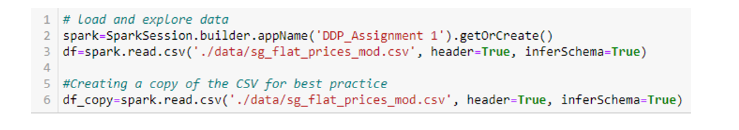

#### 6.1.2. Explore and Understand the Data <a id="part1.2"></a>

Additionally, the various features in PySpark allowed me to better understand the data before doing any form of data wrangling. For instance, upon exploring the dtypes of the variables, I found the column ‘block’ to be classes as a string. Initially I thought it was an error when PySpark was identifies the type. However, it was found that block can contain alphabets such as “123A”. Hence, being classed as a string.


#### 6.1.3. Value Based Problem Statement <a id="part1.3"></a>

Given the variables of the HDB such as the year it was sold, the age of the flat when it was sold, the type of flat, and other variables finds the resale price of a given HDB flat. 
This would allow potential HDB buyers to gauge the costs of an HDB flat given a set of variables and details which will give these buyers the convenience to know if they can afford an HDB flat given the conditions and find out if the prices are matched to previous sales.

<div style="text-align: right"> Word count for Section 6.1: 199</div>

### 6.2. Exploratory Data Analysis and Data Cleansing <a id="part2"></a>
[Back to top](#top)

#### 6.2.1. Interesting Trends <a id="part2.1"></a>

An interesting trend is that the average resale price of each storey range gradually increases as the storey increase. However, from ranges 43 to 51, there is a decrease in resale price which could mean that those levels are potentially no longer as desirable or could just be due to the count of the data being particularly low as shown below.

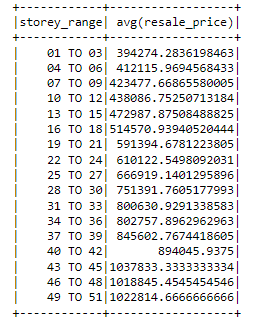




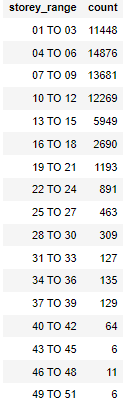

#### 6.2.2. Anomalies <a id="part2.2"></a>

No anomalies were found by looking at the distinct data, for example, I observed no instances whereby the same data have different naming conventions but the same meaning. 


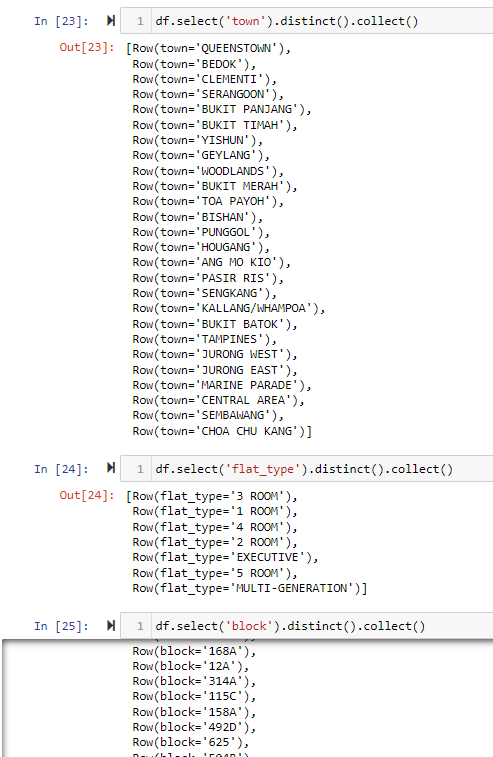

#### 6.2.3. Potential Errors <a id="part2.3"></a>

A potential error is that the remaining lease columns are in months and not years. This is an assumption as the metadata was not given and the remaining lease column contains large values. Additionally, it would be logical based on the fact that HDB flats only have a maximum 99-year lease with no freehold HDB available. However, without the metadata, we can only assume. As such, the columns were not converted from months to years which would have improved readability. 

#### 6.2.4. Missing Value Treatment <a id="part2.4"></a>

It was found that 50 rows of data had missing values and they all resided in the ‘flat_age_of_sale’ column. Upon further inspection, they were not the only rows of data for any specific column. As such, it was decided to do a closed case analysis where we drop the 50 rows of data which resulted in the total number of data dropping from 64,248 to 64,197. Median and mean imputer was also used to replace the null value.


<div style="text-align: right"> Word count for Section 6.2: 247</div>

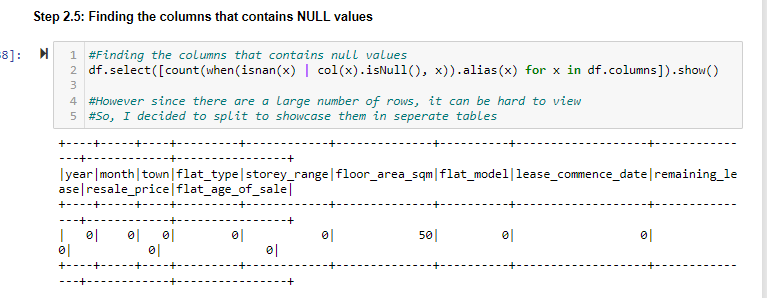

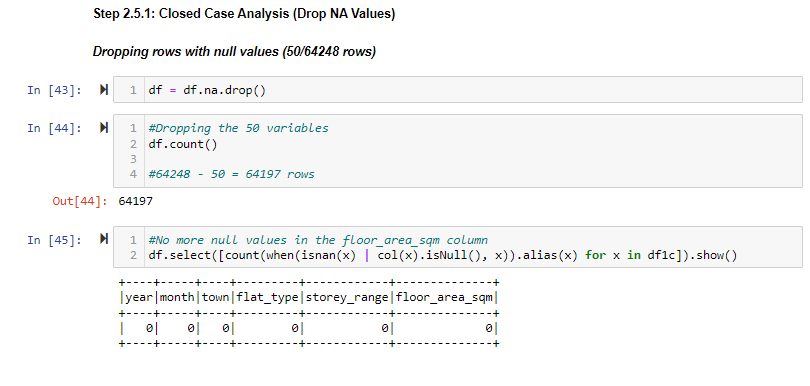

### 6.3. Data Wrangling and Transformation <a id="part3"></a>
[Back to top](#top)

#### 6.3.1. Categorical Data <a id="part3.1"></a>

String indexing and one hot encoding were used to encode the categorical data from string to a numerical form in preparation for the machine learning model. Of the two, personally, string indexing is preferred as it is more intuitive and simpler to read. However, both methods were used to enable us the option. Eventually, it was found that one hot encoding produced a much better result. Thus, one hot encoding was used in the end.

#### 6.3.2. Numerical Data <a id="part3.2"></a>

The Z-score transformation was done after vectoring to ensure that the data is better organised and it improves the overall stability of numerical models in linear regression models. Additionally, it helps to speed up the training process.

#### 6.3.3. Others (Dropping & Addition of Columns) <a id="part3.3"></a>

Columns “block” and “street_name” were dropped as they were not necessary and it improves overall model efficiency. Additionally, “flat_age_of_sale” was added by subtracting the “lease_commence_date” from the “year” to get the age of the flat when it was sold as that could be a useful value-added factor in predicting the resale price of the flat.

<div style="text-align: right"> Word count for Section 6.3: 167</div>

### 6.4. Machine Learning Modelling <a id="part4"></a>
[Back to top](#top)

#### 6.4.1. Show Count of Rows and Columns <a id="part4.1"></a>

The train test split was done at 80% for train data and 20% for test data. As such, the train data has 51,362 rows of data and 11 columns. Test data has 12,835 rows of data and 11 columns. The rows add up to the total number of rows of data before the transformation. This is done to ensure that there are sufficient amounts of data after transformation for the prediction model to ensure it will not be ridiculously accurate or inaccurate due to the lack of data.

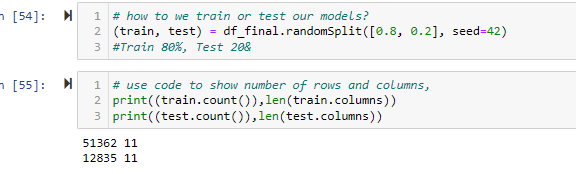

#### 6.4.2. Sample of 10 Rows before Modelling <a id="part4.2"></a>

Likewise, the sampling of 10 rows of data before modelling is to check and ensure the data is good to go before the machine learning process.

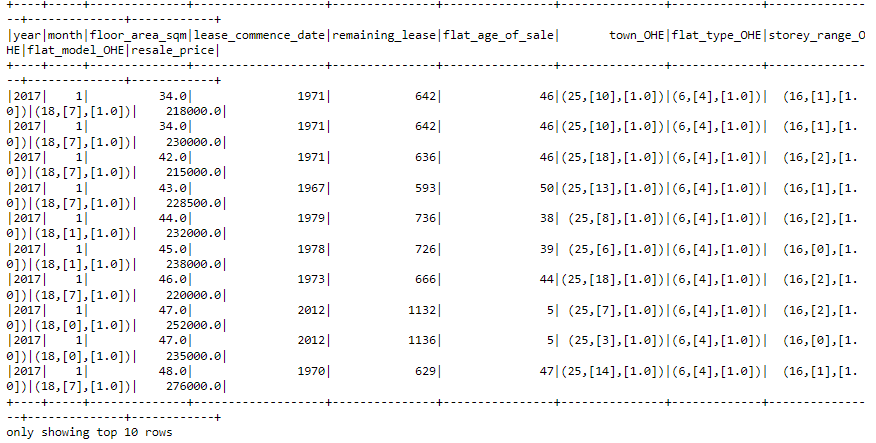

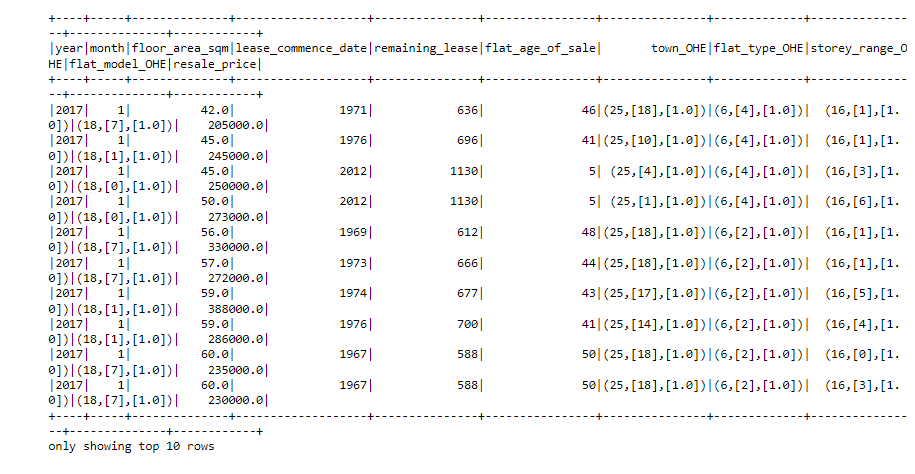

#### 6.4.3. Build the Predictive Model <a id="part4.3"></a>

The machine learning predictive model built is a regression model as the target is the resale price of HDB flats which are numerical. The model is then fitted and run with the end product showing the input which is the Xcols_sscaled, the original target resale price, and the ultimate prediction the model came up with. From there, we can compare it on the train and test data to evaluate the accuracy of the model.

<div style="text-align: right"> Word count for Section 6.4: 188</div>

### 6.5. Model Evaluation and Selection <a id="part5"></a>
[Back to top](#top)

#### 6.5.1. Utilize Model Metrics for Evaluation <a id="part5.1"></a>

After the machine learning prediction model was used and the predicted outcome was produced, it is not a definitive or conclusive way to show how accurate a given model is. As such, there is a set of formulas that are used to showcase the accuracy of a model. 


In this case, mean absolute error, mean squared error and r squared were used to test model accuracy for the train and test data. 


Overall, the mean absolute error and mean squared error for both data were very large. However, both r-squared values seem satisfactory with at least a 0.8 out of the maximum possible 1. Additionally, it is found that generally, the test data was ever so slightly more accurate than the train data in this particular outcome.


Additionally, we can try to predict on a smaller scale and we can find the difference in resale price between the actual and predicted.


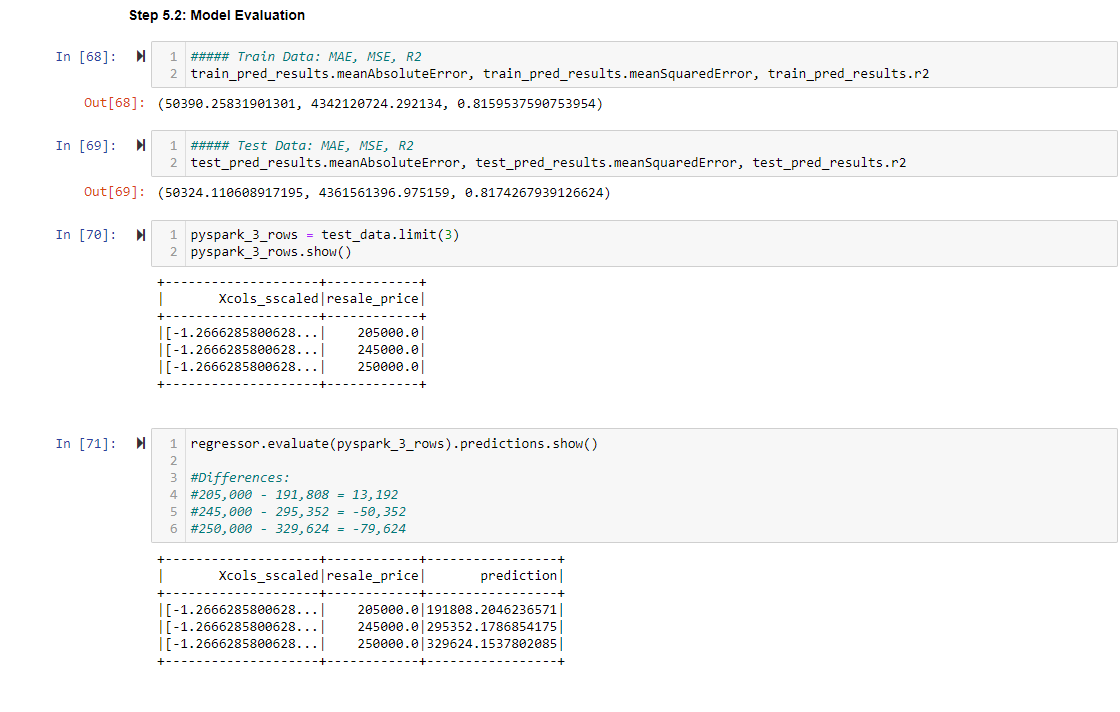

#### 6.5.2. Compare Models and Decide on Final Model <a id="part5.2"></a>

Comparing the models when using string indexing and one hot encoding shows that one hot encoding produces a significantly more accurate model as compared to that produced by string indexing. As such, as explained earlier, one hot encoding will be used for the categorical data encoding due to the much better accuracy of the model.
<div style="text-align: right"> Word count for Section 6.4: 206</div>

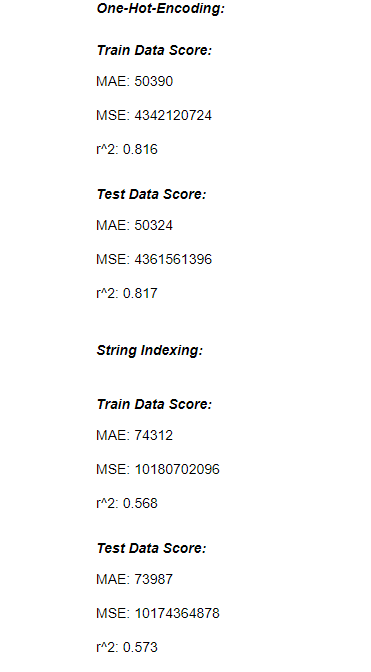

### 6.6. Summary and Further Improvements <a id="part6"></a>
[Back to top](#top)

#### 6.6.1. Summarise your Findings <a id="part6.1"></a>

Overall, the model prediction was satisfactory in terms of the accuracy of the prediction. We found that with the given variables, we decently predict the resale price of the given HDB flat with just several factors which will aid buyers in gauging the costs of the HDB flat in a certain town with a given set of variables.


Additionally, buyers would be able to refer to the model and find out if the price quoted to them for a specific unit is competitive and comparable to ensure that the end user is not getting ripped off.

#### 6.6.2. Explain the Possible Further Improvements <a id="part6.2"></a>

A possible area for improvement could be the handling of missing values as simply removing them may not prove best for the accuracy of the model prediction. However, I deemed it acceptable given the small number of null values present.


Additionally, more variables can be given to predict the resale price of HDB. For example, the number of bathrooms can be given or proximity to a bus stop, food centre, shopping mall, and other variables can be added to aid the accuracy of the model.

<div style="text-align: right"> Word count for Section 6.4: 181</div>

### "Unlisted" Youtube Link to Video Presentation
[Back to top](#top)

In [77]:
# insert your link in this cell, you are allowed to comment it out
# youtube link: https://youtu.be/Ka2oAPzVAro